# 10 - Bias Demonstration Notebook  

Evaluate and demonstrate bias in the model predictions using metrics, statistical tests, and explainability techniques. This includes GoodFit rate analysis across demographics, confusion matrices for subgroups, calibration checks, and SHAP analysis for feature contributions.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import shap
import scipy.stats as stats
import pickle
import json

/Users/markuskuehnle/Documents/projects/bias-fairness-mvp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Display all rows and columns
pd.set_option('display.max_colwidth', None)  # Show full content in each cell
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns

In [68]:
MODEL_PATH: str = "../models/xgb_model.pkl"
FEATURE_LIST_PATH: str = "../models/features.json"

In [69]:
df = pd.read_parquet("../app/data/static_data.parquet")

In [70]:
# Load the model
with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)

In [71]:
# Function to load the feature list
def load_feature_list(feature_list_path: str) -> list:
    """
    Load the feature list from a JSON file.

    Parameters:
        feature_list_path (str): Path to the feature list file.

    Returns:
        list: List of feature names.
    """
    with open(feature_list_path, "r") as f:
        return json.load(f)

In [72]:
# Load the feature list
feature_list: list = load_feature_list(FEATURE_LIST_PATH)

In [73]:
# Filter the dataset to include only relevant features
data_filtered: pd.DataFrame = df[feature_list]

In [74]:
# Ensure numeric data for all columns in data_filtered
data_filtered = data_filtered.apply(pd.to_numeric, errors="coerce")

In [75]:
# Make predictions
predictions: pd.Series = model.predict_proba(data_filtered)[:, 1]  # Probability of being a good fit

In [76]:
# Add predictions and "Good Fit" label to the dataset
df["Prediction_Probability"] = predictions
df["GoodFit"] = df["Prediction_Probability"] >= 0.5

In [77]:
df.head()

,Candidate_ID,Position_IT Support,Position_Production Technician I,Position_Area Sales Manager,Position_Production Manager,Position_Production Technician II,Position_Sales Manager,Position_Enterprise Architect,Position_Network Engineer,Position_Sr. Network Engineer,Position_Database Administrator,Position_Data Analyst,Position_Software Engineer,Position_Sr. DBA,Position_Sr. Accountant,Position_Administrative Assistant,Position_Accountant I,Position_Shared Services Manager,Position_IT Director,Position_CIO,Position_Principal Data Architect,Position_IT Manager - DB,Position_IT Manager - Support,Position_IT Manager - Infra,Position_BI Developer,Position_Senior BI Developer,Position_Data Architect,Position_BI Director,Position_Director of Sales,Position_Director of Operations,Position_Software Engineering Manager,Position_President & CEO,State,Sex,CitizenDesc_US Citizen,CitizenDesc_Eligible NonCitizen,CitizenDesc_Non-Citizen,HispanicLatino,RaceDesc_White,RaceDesc_Black or African American,RaceDesc_Asian,RaceDesc_American Indian or Alaska Native,RaceDesc_Hispanic,RaceDesc_Two or more races,Department_IT/IS,Department_Production,Department_Sales,Department_Software Engineering,Department_Admin Offices,Department_Executive Office,Age,YearsExperience,AgeGroup,ExperienceCategory,Education,Advanced Backup Strategies,Advanced Budget Forecasting,Advanced CRM Tools,Advanced Data Modeling,Advanced Data Visualization,Advanced Financial Reporting,Advanced Firewall Configurations,Advanced ITSM Tools,Advanced Machinery Maintenance,Advanced Machinery Troubleshooting,Advanced Network Configuration,Advanced Predictive Modeling,Advanced Revenue Analysis,Advanced SQL Optimization,Advanced Troubleshooting Techniques,Advanced Visualization,Agile Development Leadership,Audit Assistance,Audit Management,Backup Strategies,Backup and Recovery,Basic Accounting,Basic Machinery Maintenance,Big Data Architecture,Big Data Solutions,Budget Oversight,Budget Planning,Budget Strategy,Business Intelligence Strategy,Business Intelligence Tools,Business-IT Alignment,CI/CD Pipeline Management,Cloud Data Management,Cloud Data Solutions,Cloud Database Solutions,Cloud Integration,Cloud Networking,Cloud Strategy,Cloud-Native Data Architectures,Code Review Practices,Competitor Analysis,Cost Reduction Techniques,Customer Communication,Customer Relationship Management,Customer Retention,Customer Support,Customer Support Strategies,Cybersecurity Oversight,Dashboard Creation,Data Governance,Data Lake Architecture,Data Modeling,Data Pipeline Optimization,Data Pipeline Scalability,Data Security,Data Visualization,Database Design,Database Management,Database Tuning,Disaster Recovery Planning,Distributed Database Management,Document Management,ETL Automation,ETL Development,ETL Optimization,Efficiency Optimization,Enterprise Data Strategy,Financial Management,Financial Reporting,Firewall Expertise,Firewall Management,Forensic Accounting Techniques,Governance and Standards,Hardware Maintenance,Hardware Management,Hybrid Cloud Infrastructure Management,IT Governance,IT Security Oversight,IT Support Management,Incident Response Planning,Infrastructure Design,Java,Leadership,Leadership Skills,Lean Manufacturing,Machine Learning,Machine Learning Integration,Market Analysis,Microservices Architecture Design,Negotiation,Network Configuration,Network Management,Network Performance Optimization,Network Security Design,Office Coordination,Operations Performance Metrics,Operations Strategy,Performance Tuning,Predictive Analytics Integration,Preventive Maintenance Planning,Problem Identification,Problem-Solving,Process Improvement,Process Optimization,Production Line Efficiency Analysis,Public Relations,Python,Quality Assurance,QuickBooks,Real-Time Data Processing,Revenue Optimization,Risk Assessment,SD-WAN Deployment,SQL,SQL Optimization,Safety Protocols,Sales Funnel Optimization,Sales Strategy,Scheduling,Service Delivery Optimization,Software Design,Solution Architecture,Statistical Analysi

## Bias Metrics to Calculate


In [78]:
# Define demographic groups for analysis
demographic_columns = ['Sex', 'RaceDesc_White', 'RaceDesc_Black or African American', 'RaceDesc_Asian', 'Age']

**Calculate Demographic Parity**

In [79]:
# GoodFit rates by demographic groups
for col in demographic_columns:
    print(f"GoodFit Rates for {col}:")
    print(df.groupby(col)['GoodFit'].mean())
    print("\n")


GoodFit Rates for Sex:
Sex
0    0.812030
1    0.795229
Name: GoodFit, dtype: float64


GoodFit Rates for RaceDesc_White:
RaceDesc_White
0    0.917763
1    0.765046
Name: GoodFit, dtype: float64


GoodFit Rates for RaceDesc_Black or African American:
RaceDesc_Black or African American
0    0.783231
1    0.915789
Name: GoodFit, dtype: float64


GoodFit Rates for RaceDesc_Asian:
RaceDesc_Asian
0    0.792220
1    0.921053
Name: GoodFit, dtype: float64


GoodFit Rates for Age:
Age
32    1.000000
33    0.909091
34    1.000000
35    0.510638
36    0.960784
37    0.950000
38    0.800000
39    0.756757
40    0.660377
41    0.823529
42    0.948276
43    0.804878
44    0.733333
45    0.915493
46    0.653061
47    0.790323
48    0.857143
49    0.928571
50    0.810127
51    0.625000
52    0.636364
54    0.679245
55    0.960000
56    0.971429
57    0.838710
58    0.909091
59    0.500000
60    0.461538
63    0.625000
65    1.000000
66    1.000000
69    1.000000
72    1.000000
74    1.000000
Name: Goo

In [80]:
def _chi2_test(df, column, target):
    """
    Perform a chi-squared test for independence between a categorical column and target variable.
    
    Args:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The categorical column to test.
        target (str): The target variable (binary).
    
    Returns:
        dict: Chi-squared test results with Chi2 value, P-value, and Degrees of Freedom.
    """
    contingency_table = pd.crosstab(df[column], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    return {"Chi2": chi2, "P-Value": p, "Degrees of Freedom": dof}


# Perform chi-squared tests for specified columns
columns_to_test = ["Sex", "RaceDesc_White", "RaceDesc_Black or African American", "RaceDesc_Asian"]
results = {col: _chi2_test(df, col, "GoodFit") for col in columns_to_test}

results


{'Sex': {'Chi2': np.float64(0.4132015620969667),
  'P-Value': np.float64(0.5203489755644433),
  'Degrees of Freedom': 1},
 'RaceDesc_White': {'Chi2': np.float64(32.41921524135085),
  'P-Value': np.float64(1.242517679314792e-08),
  'Degrees of Freedom': 1},
 'RaceDesc_Black or African American': {'Chi2': np.float64(16.96077187727458),
  'P-Value': np.float64(3.8160183270674855e-05),
  'Degrees of Freedom': 1},
 'RaceDesc_Asian': {'Chi2': np.float64(10.064078305767515),
  'P-Value': np.float64(0.0015118818166870406),
  'Degrees of Freedom': 1}}

**Analyze Equality of Opportunity**

In [81]:
# GoodFit rates for qualified candidates
qualified = df[df['YearsExperience'] > 5]  # Example qualification
for col in demographic_columns:
    print(f"GoodFit Rates for Qualified Candidates ({col}):")
    print(qualified.groupby(col)['GoodFit'].mean())
    print("\n")

GoodFit Rates for Qualified Candidates (Sex):
Sex
0    0.812030
1    0.795229
Name: GoodFit, dtype: float64


GoodFit Rates for Qualified Candidates (RaceDesc_White):
RaceDesc_White
0    0.917763
1    0.765046
Name: GoodFit, dtype: float64


GoodFit Rates for Qualified Candidates (RaceDesc_Black or African American):
RaceDesc_Black or African American
0    0.783231
1    0.915789
Name: GoodFit, dtype: float64


GoodFit Rates for Qualified Candidates (RaceDesc_Asian):
RaceDesc_Asian
0    0.792220
1    0.921053
Name: GoodFit, dtype: float64


GoodFit Rates for Qualified Candidates (Age):
Age
32    1.000000
33    0.909091
34    1.000000
35    0.510638
36    0.960784
37    0.950000
38    0.800000
39    0.756757
40    0.660377
41    0.823529
42    0.948276
43    0.804878
44    0.733333
45    0.915493
46    0.653061
47    0.790323
48    0.857143
49    0.928571
50    0.810127
51    0.625000
52    0.636364
54    0.679245
55    0.960000
56    0.971429
57    0.838710
58    0.909091
59    0.500000

In [82]:
# Calculate GoodFit rates for each demographic column
print("GoodFit Rates by Demographic Group")
for col in demographic_columns:
    if col == 'Age':
        # For Age, we print the rates by individual age first
        print(f"GoodFit Rates for {col}:")
        print(df.groupby(col)['GoodFit'].mean())
    else:
        print(f"GoodFit Rates for {col}:")
        print(df.groupby(col)['GoodFit'].mean())
    print("\n")

GoodFit Rates by Demographic Group
GoodFit Rates for Sex:
Sex
0    0.812030
1    0.795229
Name: GoodFit, dtype: float64


GoodFit Rates for RaceDesc_White:
RaceDesc_White
0    0.917763
1    0.765046
Name: GoodFit, dtype: float64


GoodFit Rates for RaceDesc_Black or African American:
RaceDesc_Black or African American
0    0.783231
1    0.915789
Name: GoodFit, dtype: float64


GoodFit Rates for RaceDesc_Asian:
RaceDesc_Asian
0    0.792220
1    0.921053
Name: GoodFit, dtype: float64


GoodFit Rates for Age:
Age
32    1.000000
33    0.909091
34    1.000000
35    0.510638
36    0.960784
37    0.950000
38    0.800000
39    0.756757
40    0.660377
41    0.823529
42    0.948276
43    0.804878
44    0.733333
45    0.915493
46    0.653061
47    0.790323
48    0.857143
49    0.928571
50    0.810127
51    0.625000
52    0.636364
54    0.679245
55    0.960000
56    0.971429
57    0.838710
58    0.909091
59    0.500000
60    0.461538
63    0.625000
65    1.000000
66    1.000000
69    1.000000
72  

In [83]:
# For Age, create bins for a categorical analysis
age_bins = [20, 30, 40, 50, 60, 70, 80]  # adjust the bins as appropriate
age_labels = ["20-29", "30-39", "40-49", "50-59", "60-69", "70-79"]
df["Age_Bin"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=False)

In [84]:
print("GoodFit Rates for Age Bins:")
print(df.groupby("Age_Bin")["GoodFit"].mean())
print("\n")

GoodFit Rates for Age Bins:
Age_Bin
20-29         NaN
30-39    0.816254
40-49    0.813592
50-59    0.774194
60-69    0.795918
70-79    1.000000
Name: GoodFit, dtype: float64




/var/folders/0z/26cwjfqx4fj73hndqg4mkgl80000gn/T/ipykernel_69803/1359875830.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("Age_Bin")["GoodFit"].mean())


In [85]:
def _chi2_test(df, column, target):
    """
    Perform a chi-squared test for independence between a categorical column and target variable.
    
    Args:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The categorical column to test.
        target (str): The target variable (binary).
    
    Returns:
        dict: Chi-squared test results with Chi2 value, P-value, and Degrees of Freedom.
    """
    contingency_table = pd.crosstab(df[column], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    return {"Chi2": chi2, "P-Value": p, "Degrees of Freedom": dof}


In [86]:
# Perform chi-squared tests for each of these columns against GoodFit
chi2_results = {col: _chi2_test(df, col, "GoodFit") for col in columns_to_test}

print("Chi-Squared Test Results")
for col, result in chi2_results.items():
    print(f"{col}: {result}")

Chi-Squared Test Results
Sex: {'Chi2': np.float64(0.4132015620969667), 'P-Value': np.float64(0.5203489755644433), 'Degrees of Freedom': 1}
RaceDesc_White: {'Chi2': np.float64(32.41921524135085), 'P-Value': np.float64(1.242517679314792e-08), 'Degrees of Freedom': 1}
RaceDesc_Black or African American: {'Chi2': np.float64(16.96077187727458), 'P-Value': np.float64(3.8160183270674855e-05), 'Degrees of Freedom': 1}
RaceDesc_Asian: {'Chi2': np.float64(10.064078305767515), 'P-Value': np.float64(0.0015118818166870406), 'Degrees of Freedom': 1}


- **Sex**:  
  In our dataset, sex is encoded as 0 for Female and 1 for Male. The GoodFit rate is approximately 81.2% for Females and 79.5% for Males. The chi-squared test (p ≈ 0.520) indicates that this difference is not statistically significant, suggesting little evidence of bias based on sex.

- **RaceDesc_White**:  
  Candidates with RaceDesc_White = 0 (non-White) have a GoodFit rate of about 91.8%, while those with RaceDesc_White = 1 (White) have a rate of roughly 76.5%. This difference is highly significant (p ≈ 1.24e-08), indicating potential bias.

- **RaceDesc_Black or African American**:  
  The GoodFit rate is around 78.3% for candidates with a value of 0 (non-Black) and 91.6% for those with a value of 1 (Black). The chi-squared test (p ≈ 3.82e-05) suggests that this difference is statistically significant, indicating potential bias.

- **RaceDesc_Asian**:  
  Candidates with RaceDesc_Asian = 0 (non-Asian) have a GoodFit rate of about 79.2%, compared to approximately 92.1% for candidates with RaceDesc_Asian = 1 (Asian). The difference is statistically significant (p ≈ 0.00151), suggesting potential bias.

- **Age**:  
  GoodFit rates vary substantially by age. For example, when examining individual ages, rates range from around 51.1% (e.g., age 35) to 100% for several ages (e.g., 32, 34, 65, 66, 69, 72, 74). When grouped into bins, the average GoodFit rates are roughly 81.6% for ages 30–39, 81.4% for ages 40–49, 77.4% for ages 50–59, 79.6% for ages 60–69, and 100% for ages 70–79. Although the differences across age bins are less pronounced than those seen in some racial subgroups, this variability suggests that age may also influence model predictions and warrants further investigation.

*Note: These metrics were recalculated after removing the HispanicLatino attribute from the dataset.*

## Counterfactual Fairness

In [6]:
# Read the pre-computed predictions file.
results_df = pd.read_parquet("../app/data/static_predictions.parquet")

In [7]:
def compute_avg_max_probability_change(df: pd.DataFrame) -> float:
    """
    Compute the average maximum absolute change in prediction probability for each candidate.
    
    For each candidate, find the original prediction (where Modified_Attribute is NaN) and
    compute the maximum absolute difference in prediction probability from any counterfactual.
    Finally, return the average of these maximum differences.
    """
    candidate_changes = []
    groups = df.groupby("Candidate_ID")
    for candidate, group in groups:
        # Find the original row (where no attribute was modified)
        original_row = group[group["Modified_Attribute"].isna()]
        if original_row.empty:
            continue
        original_prob = original_row.iloc[0]["Prediction_Probability"]
        # Get all rows with modifications
        modifications = group[group["Modified_Attribute"].notna()]
        if not modifications.empty:
            max_diff = modifications["Prediction_Probability"].apply(lambda x: abs(x - original_prob)).max()
            candidate_changes.append(max_diff)
        else:
            candidate_changes.append(0)
    return np.mean(candidate_changes) if candidate_changes else 0

def compute_flip_rate(df: pd.DataFrame) -> float:
    """
    Compute the flip rate: the proportion of candidates whose GoodFit label flips 
    (changes from the original) under at least one counterfactual modification.
    """
    groups = df.groupby("Candidate_ID")
    flips = 0
    total = 0
    for candidate, group in groups:
        total += 1
        original_row = group[group["Modified_Attribute"].isna()]
        if original_row.empty:
            continue
        original_goodfit = original_row.iloc[0]["GoodFit"]
        modification_rows = group[group["Modified_Attribute"].notna()]
        if any(modification_rows["GoodFit"] != original_goodfit):
            flips += 1
    return flips / total if total > 0 else 0

In [8]:
# Calculate the fairness metrics
avg_max_prob_change = compute_avg_max_probability_change(results_df)
flip_rate = compute_flip_rate(results_df)

print("Average Maximum Change in Prediction Probability (Counterfactual Fairness Metric):", avg_max_prob_change)
print("Flip Rate (Proportion of Candidates with GoodFit Change):", flip_rate)

Average Maximum Change in Prediction Probability (Counterfactual Fairness Metric): 0.8101998
Flip Rate (Proportion of Candidates with GoodFit Change): 1.0


These results mean that on average, when you change a protected attribute (like sex, age, or race) for a candidate, the prediction probability shifts by about 81 percentage points. In addition, the flip rate of 1.0 (or 100%) indicates that every candidate's GoodFit label changes under at least one counterfactual modification (due to filtering).

Overall Counterfactual Changes:
Average Change: 0.5399411
Median Change: 0.5970941
Variance: 0.1098562


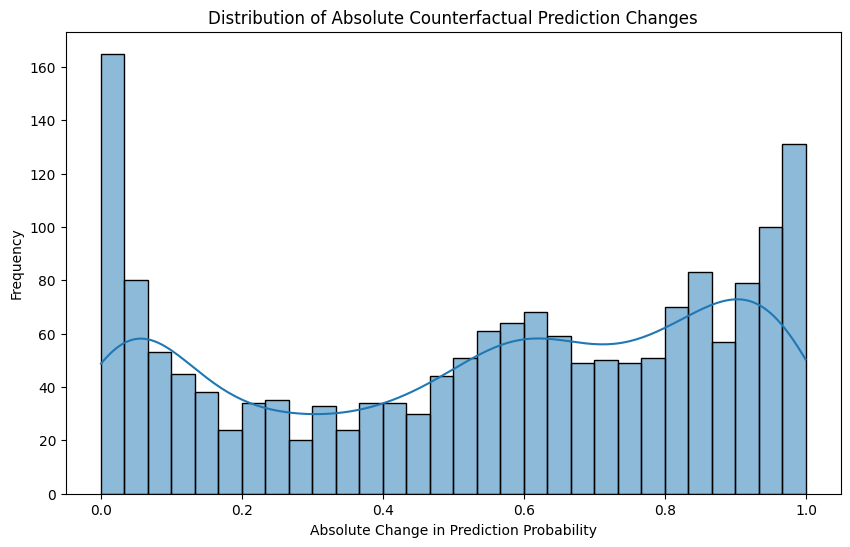


Attribute: Sex
  Average Change: 0.3592
  Median Change: 0.3094


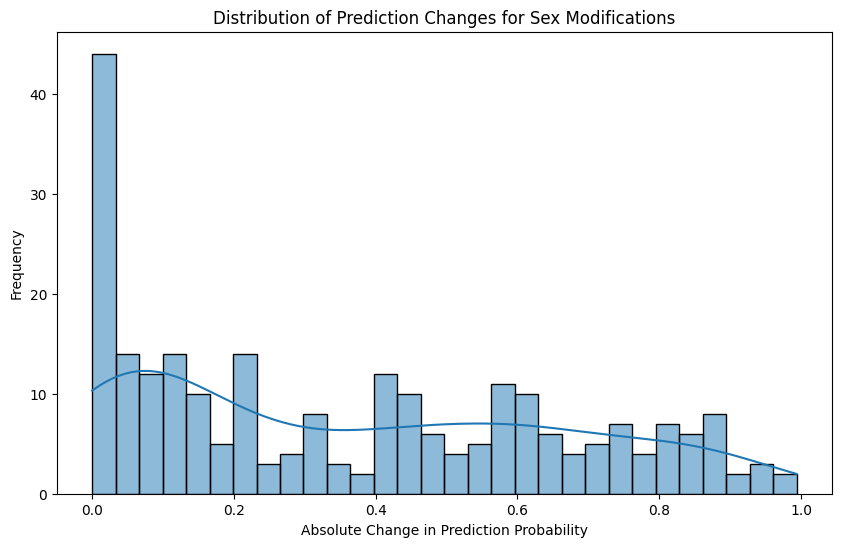


Attribute: Age
  Average Change: 0.5934
  Median Change: 0.6570


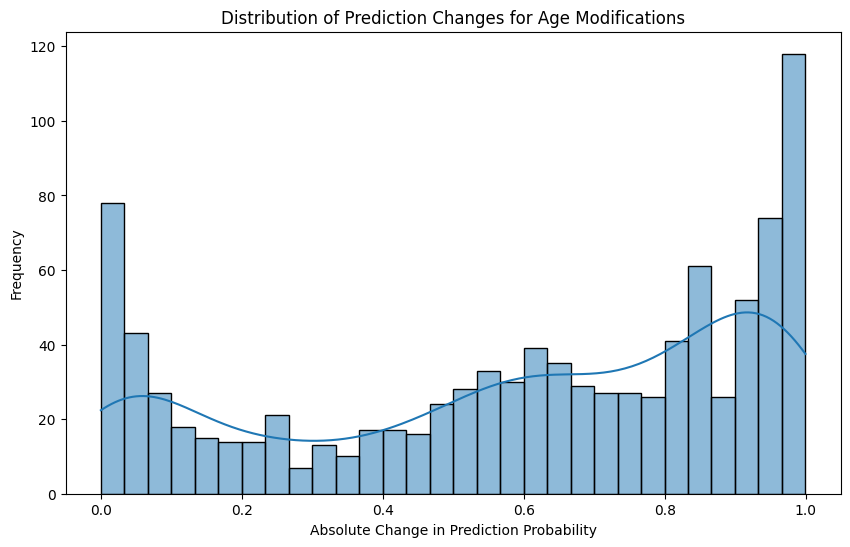


Attribute: Race
  Average Change: 0.5233
  Median Change: 0.5802


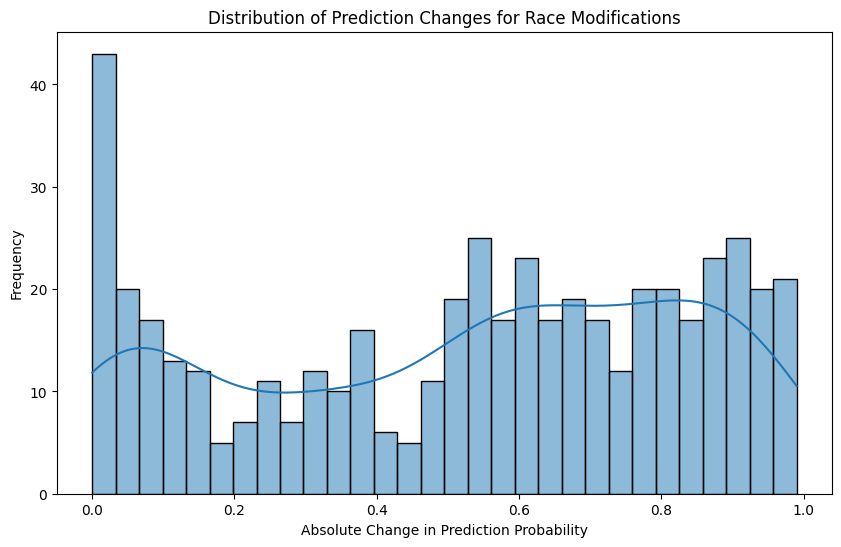

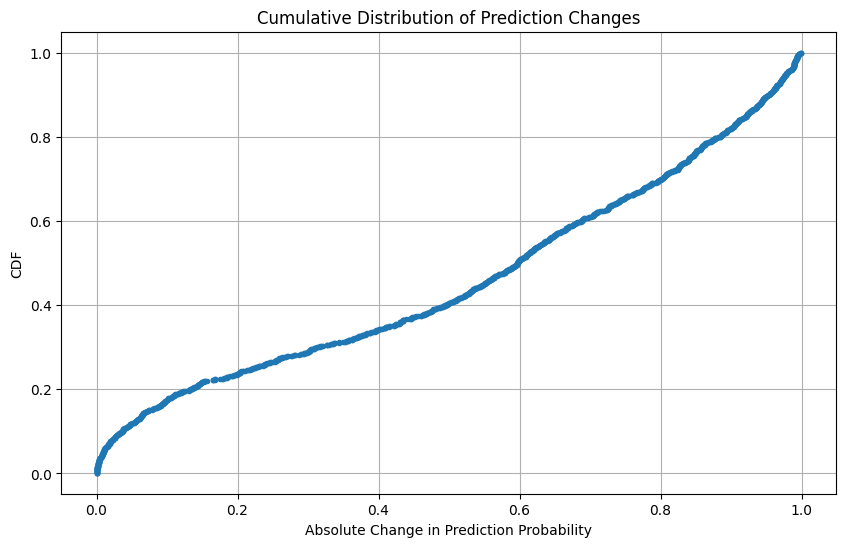

In [9]:
# Separate original predictions and counterfactual modifications
original = results_df[results_df['Modified_Attribute'].isna()][['Candidate_ID', 'Prediction_Probability']]
original = original.rename(columns={'Prediction_Probability': 'Original_Probability'})

# Merge the original predictions back with the modified rows
modified = results_df[results_df['Modified_Attribute'].notna()]
merged = pd.merge(modified, original, on='Candidate_ID', how='left')

# Calculate the absolute change in prediction probability
merged['Probability_Change'] = (merged['Prediction_Probability'] - merged['Original_Probability']).abs()

# Print summary statistics for overall counterfactual changes
print("Overall Counterfactual Changes:")
print("Average Change:", merged['Probability_Change'].mean())
print("Median Change:", merged['Probability_Change'].median())
print("Variance:", merged['Probability_Change'].var())

# Plot the overall distribution of absolute changes
plt.figure(figsize=(10, 6))
sns.histplot(merged['Probability_Change'], bins=30, kde=True)
plt.xlabel('Absolute Change in Prediction Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Counterfactual Prediction Changes')
plt.show()

# Breakdown by modified attribute
for attr in merged['Modified_Attribute'].unique():
    subset = merged[merged['Modified_Attribute'] == attr]
    avg_change = subset['Probability_Change'].mean()
    median_change = subset['Probability_Change'].median()
    print(f"\nAttribute: {attr}")
    print(f"  Average Change: {avg_change:.4f}")
    print(f"  Median Change: {median_change:.4f}")
    
    plt.figure(figsize=(10, 6))
    sns.histplot(subset['Probability_Change'], bins=30, kde=True)
    plt.xlabel('Absolute Change in Prediction Probability')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Prediction Changes for {attr} Modifications')
    plt.show()

# Plot a cumulative distribution (CDF) for overall changes
sorted_changes = merged['Probability_Change'].sort_values()
cdf = sorted_changes.rank(method='average', pct=True)

plt.figure(figsize=(10, 6))
plt.plot(sorted_changes, cdf, marker='.', linestyle='none')
plt.xlabel('Absolute Change in Prediction Probability')
plt.ylabel('CDF')
plt.title('Cumulative Distribution of Prediction Changes')
plt.grid(True)
plt.show()

Summary of the counterfactual analysis findings:

1. **Overall Counterfactual Changes**  
   - **Average Absolute Change:** ~0.54  
   - **Median Absolute Change:** ~0.60  
   - **Variance:** ~0.11  

   This indicates that, on average, flipping a candidate’s protected attribute (sex, age, or race) results in more than a 50% absolute shift in their predicted probability of being a “Good Fit.” The changes are widely distributed: some are minimal, but many shift the model’s output substantially (close to 1.0).

2. **By Attribute**  
   - **Sex**  
     - **Average Change:** ~0.36  
     - **Median Change:** ~0.31  
     This is the smallest among the three attributes, suggesting the model is somewhat less sensitive to changes in sex alone.
   
   - **Age**  
     - **Average Change:** ~0.59  
     - **Median Change:** ~0.66  
     Age modifications show the largest overall impact, meaning altering age bins can cause particularly large swings in predicted probability.
   
   - **Race**  
     - **Average Change:** ~0.52  
     - **Median Change:** ~0.58  
     Shifts in race also lead to substantial changes, highlighting the model’s high sensitivity to race descriptors.

3. **Distribution Insights**  
   - The **histograms** show a wide spread of absolute prediction changes. A significant number of changes cluster near 0 (small or no effect), but there is also a strong mode near 1.0, implying many cases where flipping a single attribute fully inverts the model’s probability.
   - The **CDF** (cumulative distribution function) rises roughly linearly, indicating that the magnitude of changes is well-spread from small to near-complete flips.

Overall, these results suggest that for many candidates, modifying a single protected attribute (especially age or race) can dramatically alter the model’s output. This points to potential fairness concerns, as the model appears highly sensitive to changes in certain demographic variables.